<a href="https://colab.research.google.com/github/Tiziri-k/SIC-exercices/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import string
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data 

In [ ]:
data = pd.read_csv('small_complaints.csv', engine='python', encoding='utf-8', error_bad_lines=False, sep=',')

Skipping line 5231: unexpected end of data


In [ ]:
data = data[["Product","Consumer complaint narrative"]]

In [ ]:
data.head()

,Product,Consumer complaint narrative
0,Debt collection,transworld systems inc. \nis trying to collect...
1,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...
2,Debt collection,"Over the past 2 weeks, I have been receiving e..."
3,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh..."
4,Debt collection,While checking my credit report I noticed thre...


In [ ]:
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    2349
Debt collection                                                                 1007
Credit card or prepaid card                                                      529
Mortgage                                                                         460
Checking or savings account                                                      328
Student loan                                                                     212
Vehicle loan or lease                                                            118
Money transfer, virtual currency, or money service                               109
Payday loan, title loan, or personal loan                                        104
Consumer Loan                                                                      5
Payday loan                                                                        3
Credit card                                                      

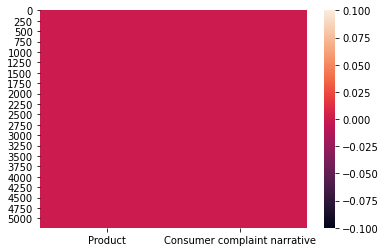

In [ ]:
sns.heatmap(data.isnull())

# Preprocessing & Vizz

In [ ]:
# We will group some product types 
data.loc[data['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
data.loc[data['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
data.loc[data['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
data.loc[data['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'


In [ ]:
# In the code below you should add : Prepaid card, Consumer Loan & Bank account or service to "Other financial service"
data.loc[data['Product'] =='Prepaid card, Consumer Loan ', 'Bank account or service '] ='Other financial service' 

# We will not consider other financial service
# Code Here
data = data[data.Product != 'Other financial service']


In [ ]:
data = data.reset_index(drop=True)

In [ ]:
data

,Product,Consumer complaint narrative,Bank account or service
0,Debt collection,transworld systems inc trying collect debt min...,NaN
1,"Credit reporting, credit repair services, or o...",would like request suppression following items...,NaN
2,Debt collection,past weeks receiving ecessive amounts telephon...,NaN
3,"Money transfer, virtual currency, or money ser...",sold access event digitally screenshots detail...,NaN
4,Debt collection,checking credit report noticed three collectio...,NaN
...,...,...,...
5224,"Credit reporting, credit repair services, or o...",identity compromised aftermath tragedy im suff...,NaN
5225,"Credit reporting, credit repair services, or o...",entry credit report claim debt called mean pro...,NaN
5226,"Credit reporting, credit repair services, or o...",fighting bureaus past year get comply law open...,NaN
5227,Vehicle loan or lease,trying work santander consumer usa months tryi...,NaN


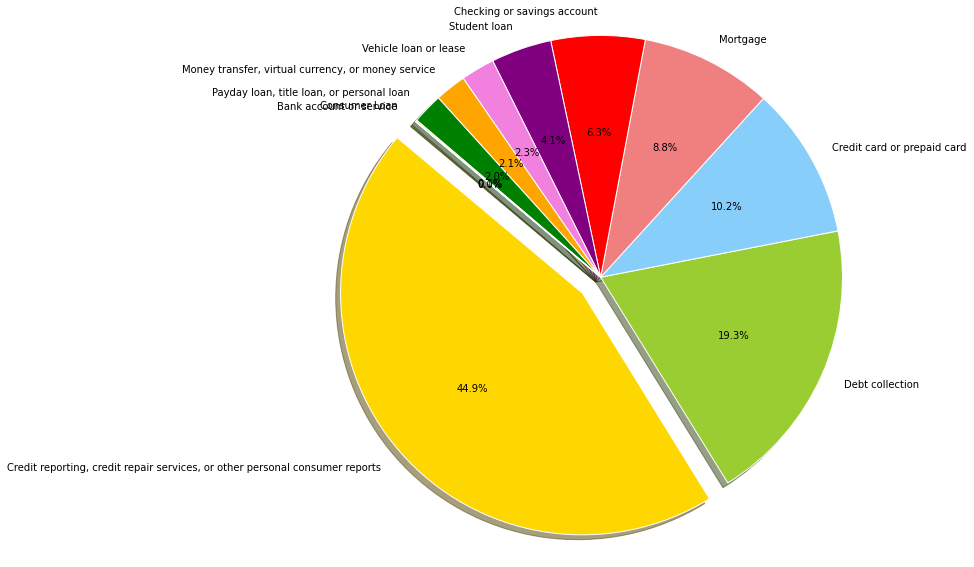

In [ ]:
# Data to plot
labels = list(data.Product.value_counts().index)
sizes = list(data.Product.value_counts().values)
colors = ['gold','yellowgreen', 'lightskyblue', 'lightcoral', 'red', 'purple', '#f280de', 'orange', 'green']
explode = (0.1, 0, 0, 0,0,0,0,0,0,0,0)  # explode 1st slice

# Plot
plt.figure(figsize=(10,10))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140, wedgeprops={"edgecolor":"white"})
plt.axis('equal')
plt.show()

In [ ]:
def complaint_product(indx,data):
  complaint = data['Consumer complaint narrative'][indx]
  product = data['Product'][indx]
  print(complaint)
  print('------------------------------')
  print("Product : ",product)

In [ ]:
complaint_product(238, data)

Financial phishing!!! Was getting XXXX hang-up calls a day from XXXX, for several weeks, finally did a dial back and it was this company Opportunity Loans. Told them I was on the No Call List and wanted no further calls. Was told they were calling about my loan application and would need last XXXX of my SSN to pull ; advised I did n't have an application so my SSN would do them no good. Advised they could use my phone number to remove from their call list and any further representation that I had a loan application was fraudulent. Since that XXXX conversation I have received XXXX more hang up calls. I also received XXXX messages left from the same company on a toll free # XXXX, ignored the XXXX thinking it in error, the XXXX came in on XXXX, my conversation with the rep XXXX went much the same as my original conversation, with them insisting they needed SSN info to stop calls ; thus far I have not received further calls from this number- yet. I believe this particularly egregious phish

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation, remove words containing numbers, remove stop words and Xs.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [ ]:
# Code Here
data['Consumer complaint narrative'] = data['Consumer complaint narrative'].apply(clean_text) # apply clean_text function 

In [ ]:
data

,Product,Consumer complaint narrative
0,Debt collection,transworld systems inc trying collect debt min...
1,"Credit reporting, credit repair services, or o...",would like request suppression following items...
2,Debt collection,past weeks receiving ecessive amounts telephon...
3,"Money transfer, virtual currency, or money ser...",sold access event digitally screenshots detail...
4,Debt collection,checking credit report noticed three collectio...
...,...,...
5224,"Credit reporting, credit repair services, or o...",identity compromised aftermath tragedy im suff...
5225,"Credit reporting, credit repair services, or o...",entry credit report claim debt called mean pro...
5226,"Credit reporting, credit repair services, or o...",fighting bureaus past year get comply law open...
5227,Vehicle loan or lease,trying work santander consumer usa months tryi...


In [ ]:
# After cleaning
complaint_product(238, data)

financial phishing getting hangup calls day several weeks finally dial back company opportunity loans told call list wanted calls told calling loan application would need last ssn pull advised nt application ssn would good advised could use phone number remove call list representation loan application fraudulent since conversation received hang calls also received messages left company toll free ignored thinking error came conversation rep went much original conversation insisting needed ssn info stop calls thus far received calls number yet believe particularly egregious phishing may triggered recent harp process bank gotten number mail offers since folks wo nt stop even told credit collections less worry given list calls apparently generated may take someone vernarable
------------------------------
Product :  Consumer Loan


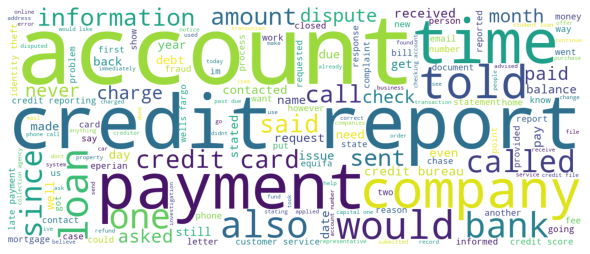

In [ ]:
text = " ".join(complaint for complaint in data["Consumer complaint narrative"])
# Generate a word cloud image

wordcloud = WordCloud(width = 1200, height = 500, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(text) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
number_words = [len(complaints.split(' ')) for complaints in data["Consumer complaint narrative"]]

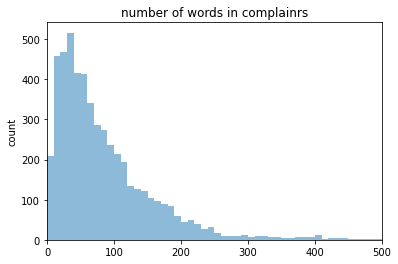

In [ ]:
# fixed bin size
bins = np.arange(-0, 3000, 10) # fixed bin size

plt.xlim([0, 500])

plt.hist(number_words, bins=bins, alpha=0.5)
plt.title('number of words in complainrs')
plt.ylabel('count')

plt.show()

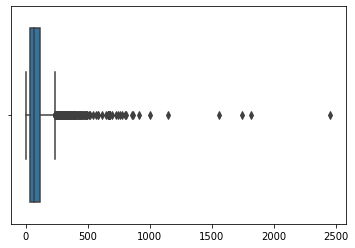

In [ ]:
sns.boxplot(number_words)

# Multi-Class Text Classification LSTM 

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 14580 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(data['Consumer complaint narrative'].values)#list of integers
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH) #padding
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5229, 250)


In [ ]:
labels = list(pd.get_dummies(data['Product']).columns)
Y = pd.get_dummies(data['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (5229, 11)


In [ ]:
# Code Here
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state =42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4706, 250) (4706, 11)
(523, 250) (523, 11)


**Expected Output :**
(35449, 250) (35449, 9)
(8863, 250) (8863, 9)

In [ ]:
# Code Here
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(13, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 13)                1313      
Total params: 5,081,713
Trainable params: 5,081,713
Non-trainable params: 0
_________________________________________________________________
None


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param   
_________________________________________________________________
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 909    
_________________________________________________________________

Total params: 5,081,309
Trainable params: 5,081,309
Non-trainable params: 0


In [ ]:
X_train.shape , Y_train.shape

((4706, 250), (4706, 11))

In [ ]:
epochs = 5
batch_size = 64
# Code Here
history = model.fit(X_train,Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

In [ ]:
# evaluate model on test set
# Code Here
score = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(score[0],score[1]))

Test set

  Loss: 0.66
  
  Accuracy: 0.80

In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
predicted_classes = np.argmax(Y_pred, axis=1)

In [ ]:
# Code Here
expected_classes = np.argmax(Y_test, axis=1)

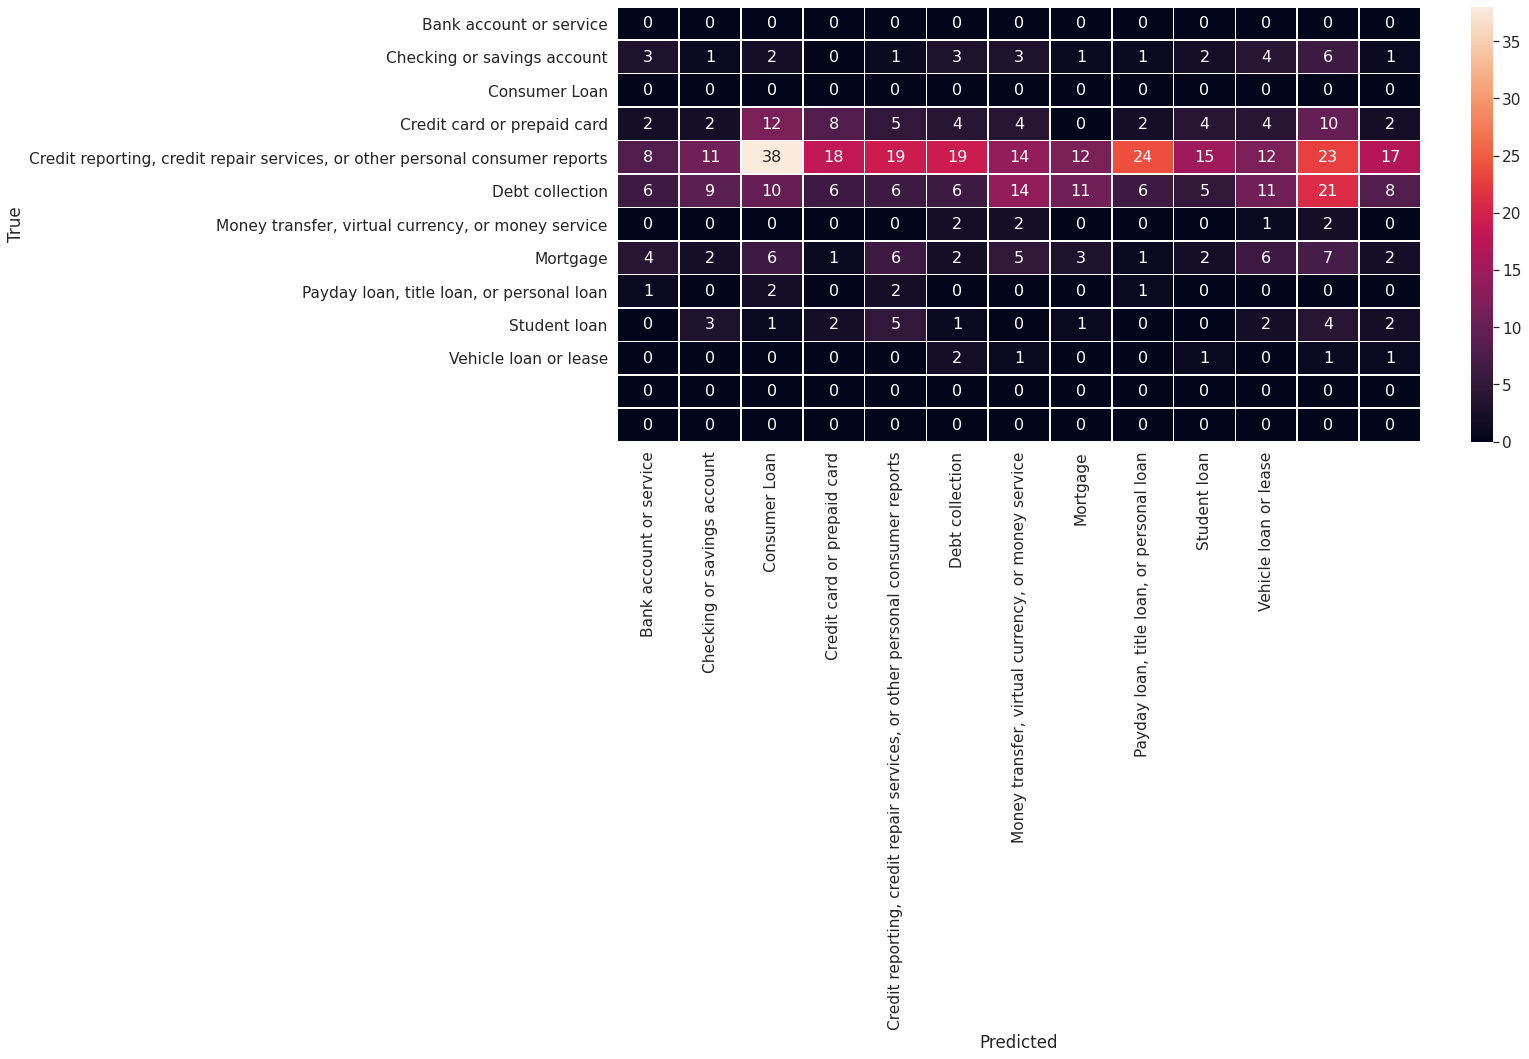

In [ ]:
cm = confusion_matrix(expected_classes, predicted_classes)
plt.figure(figsize=(18,8))
sns.set(font_scale=1.4) 
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='d',linewidths=0.5, xticklabels=labels, yticklabels=labels) 
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()